# Импорт

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from LookGenerator.datasets.person_segmentation_dataset import PersonSegmentationDataset, PersonSegmentationDatasetMultichannel
from LookGenerator.networks.segmentation import UNet, train_unet
from LookGenerator.networks.utils import load_model
import LookGenerator.datasets.transforms as custom_transforms
from LookGenerator.datasets.utils import prepare_image_for_model_transpose, to_array_from_model_transpose, show_array_multichannel
from LookGenerator.datasets.utils import prepare_image_for_model_transpose, to_array_from_model_bin_transpose
import albumentations

# Загрузка данных

In [2]:
transform_input = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.25, 0.25, 0.25]
    )
])

transform_output = transforms.Compose([
    transforms.Resize((256, 192)),
    custom_transforms.MinMaxScale(),
    custom_transforms.ThresholdTransform(threshold=0.5)
])

In [3]:
batch_size_train = 32
batch_size_val = 16

In [4]:
transform_train = albumentations.Compose([
        albumentations.Resize(height=256, width=192),
        albumentations.RandomBrightnessContrast(brightness_limit=(0.1,0.3), contrast_limit=(0.2,0.7), p =0.2),
        albumentations.Equalize(p = 0.2),
        albumentations.GaussNoise(p = 0.2),
        albumentations.Affine(translate_percent=0.1, scale=(0.8, 1), rotate=(-90,90), p=0.2),
        albumentations.Normalize(mean = (0.5, 0.5, 0.5), std = (0.25, 0.25, 0.25)),
    ])

transform_valid = albumentations.Compose([
        albumentations.Resize(height=256, width=192),
        albumentations.Normalize(mean = (0.5, 0.5, 0.5), std = (0.25, 0.25, 0.25)),
    ])

In [5]:
train_dataset = PersonSegmentationDataset("C:\\Users\\DenisovDmitrii\\Desktop\\train", augment=transform_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
(len(train_dataset), len(train_dataloader))

(2937, 92)

In [6]:
val_dataset = PersonSegmentationDataset("C:\\Users\\DenisovDmitrii\\Desktop\\test", augment=transform_valid)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)
(len(val_dataset), len(val_dataloader))

(936, 59)

Test load train_dataloader. and val.

torch.Size([32, 3, 256, 192])
torch.Size([32, 1, 256, 192])


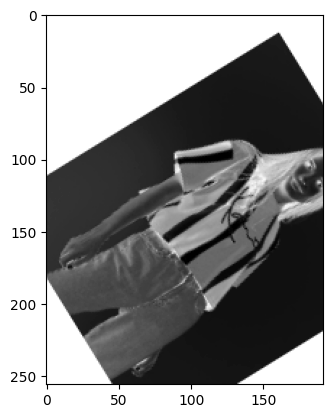

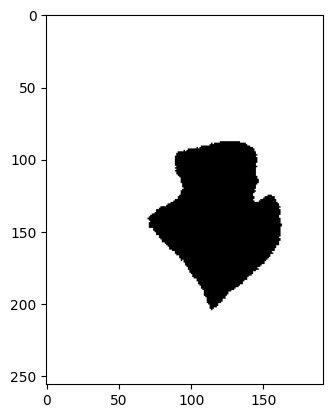

In [7]:
for X, y in train_dataloader:
    print(X.shape)
    print(y.shape)
    plt.imshow(X.detach().numpy()[0,0,:,:], cmap = 'binary')
    plt.show()
    plt.imshow(y.detach().numpy()[0,0,:,:], cmap = 'binary')
    plt.show()
    # modelled_img = to_array_from_model_bin_transpose(transform_output(X.detach()))
    # plt.imshow(modelled_img,cmap = 'binary')
    # plt.show()
    # modelled_img = to_array_from_model_bin_transpose(transform_output(y.detach()))
    # plt.imshow(modelled_img,cmap = 'binary')
    # plt.show()
    break

# Обучение модели

Метки классов на изображении:

1. Левое лицо                       248,251,14
2. Правое лицо                      251,235,25
3. Туловище                         20,80,194
4. Внешняя верхняя левая рука       190,189,96
5. Внешняя верхняя правая рука      215,187,88
6. Внешняя нижняя левая рука        252,206,48
7. Внешняя нижняя правая рука       250,220,36
8. Внутренняя верхняя левая рука    145,191,116
9. Внутренняя верхняя правая рука   170,190,105
10. Внетренняя нижняя левая рука     228,191,74
11. Внутренняя нижняя правая рука    240,198,60
12. Левая кисть                      8,110,221
13. Правая кисть                     4,98,224
14. Левая нога                       22,173,184
15. Правая нога                      6,166,198

In [8]:
model = UNet(in_channels=3, out_channels = 1)
#model = load_model(model, r'C:\Users\DenisovDmitrii\Desktop\segmentation_weits\session12\asd.pt')
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [9]:
import datetime
now = datetime.datetime.now()
print("start time", now.strftime("%d-%m-%Y %H:%M"))

train_history, val_history = train_unet(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    device=device,
    epoch_num=15,
    save_directory="C:\\Users\\DenisovDmitrii\\Desktop\\segmentation_weits\\session29"
)
old = now
now = datetime.datetime.now()
print("end time", now.strftime("%d-%m-%Y %H:%M"))
print("delta", now - old)


start time 01-03-2023 18:32


100%|██████████| 92/92 [01:00<00:00,  1.52it/s]


Epoch 0 of 14, train loss: 0.35959


100%|██████████| 59/59 [00:10<00:00,  5.74it/s]


Epoch 0 of 14, val loss: 0.25414


100%|██████████| 92/92 [01:07<00:00,  1.36it/s]


Epoch 1 of 14, train loss: 0.21103


100%|██████████| 59/59 [00:12<00:00,  4.65it/s]


Epoch 1 of 14, val loss: 0.31096


100%|██████████| 92/92 [00:56<00:00,  1.62it/s]


Epoch 2 of 14, train loss: 0.17272


100%|██████████| 59/59 [00:10<00:00,  5.64it/s]


Epoch 2 of 14, val loss: 0.15985


100%|██████████| 92/92 [01:01<00:00,  1.49it/s]


Epoch 3 of 14, train loss: 0.14507


100%|██████████| 59/59 [00:10<00:00,  5.37it/s]


Epoch 3 of 14, val loss: 0.11449


100%|██████████| 92/92 [00:53<00:00,  1.73it/s]


Epoch 4 of 14, train loss: 0.12767


100%|██████████| 59/59 [00:09<00:00,  6.13it/s]


Epoch 4 of 14, val loss: 0.11675


100%|██████████| 92/92 [00:53<00:00,  1.73it/s]


Epoch 5 of 14, train loss: 0.11241


100%|██████████| 59/59 [00:10<00:00,  5.37it/s]


Epoch 5 of 14, val loss: 0.08474


100%|██████████| 92/92 [00:58<00:00,  1.57it/s]


Epoch 6 of 14, train loss: 0.10073


100%|██████████| 59/59 [00:10<00:00,  5.58it/s]


Epoch 6 of 14, val loss: 0.07085


100%|██████████| 92/92 [01:00<00:00,  1.52it/s]


Epoch 7 of 14, train loss: 0.08971


100%|██████████| 59/59 [00:11<00:00,  5.00it/s]


Epoch 7 of 14, val loss: 0.06523


100%|██████████| 92/92 [01:05<00:00,  1.41it/s]


Epoch 8 of 14, train loss: 0.08362


100%|██████████| 59/59 [00:10<00:00,  5.84it/s]


Epoch 8 of 14, val loss: 0.06325


100%|██████████| 92/92 [01:00<00:00,  1.51it/s]


Epoch 9 of 14, train loss: 0.07975


100%|██████████| 59/59 [00:10<00:00,  5.83it/s]


Epoch 9 of 14, val loss: 0.06865


100%|██████████| 92/92 [00:59<00:00,  1.54it/s]


Epoch 10 of 14, train loss: 0.07619


100%|██████████| 59/59 [00:12<00:00,  4.92it/s]


Epoch 10 of 14, val loss: 0.05769


100%|██████████| 92/92 [01:02<00:00,  1.46it/s]


Epoch 11 of 14, train loss: 0.07444


100%|██████████| 59/59 [00:10<00:00,  5.71it/s]


Epoch 11 of 14, val loss: 0.06039


100%|██████████| 92/92 [01:04<00:00,  1.42it/s]


Epoch 12 of 14, train loss: 0.06855


100%|██████████| 59/59 [00:09<00:00,  5.98it/s]


Epoch 12 of 14, val loss: 0.06016


100%|██████████| 92/92 [00:57<00:00,  1.61it/s]


Epoch 13 of 14, train loss: 0.06407


100%|██████████| 59/59 [00:09<00:00,  5.92it/s]


Epoch 13 of 14, val loss: 0.04480


100%|██████████| 92/92 [01:01<00:00,  1.50it/s]


Epoch 14 of 14, train loss: 0.06491


100%|██████████| 59/59 [00:11<00:00,  5.14it/s]

Epoch 14 of 14, val loss: 0.05090
end time 01-03-2023 18:49
delta 0:17:48.206890


In [ ]:
model = load_model(model, r'C:\Users\Даша\PycharmProjects\SMBackEnd\LookGenerator\weights\unet_epoch_0_0.0161572862694324.pt')
model.eval()